In [1]:
import torch

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
#Sources:
#https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [3]:
DATA_DIR = './dataset'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'x_train')
y_train_dir = os.path.join(DATA_DIR, 'y_train')

x_valid_dir = os.path.join(DATA_DIR, 'x_val')
y_valid_dir = os.path.join(DATA_DIR, 'y_val')

x_test_dir = os.path.join(DATA_DIR, 'x_test')
y_test_dir = os.path.join(DATA_DIR, 'y_test')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
import os
import cv2
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt


def get_cadis_colormap():
    """
    Returns cadis colormap as in paper
    :return: ndarray of rgb colors
    """
    return np.asarray(
        [
            [0, 137, 255],
            [255, 165, 0],
            [255, 156, 201],
            [99, 0, 255],
            [255, 0, 0],
            [255, 0, 165],
            [255, 255, 255],
            [141, 141, 141],
            [255, 218, 0],
            [173, 156, 255],
            [73, 73, 73],
            [250, 213, 255],
            [255, 156, 156],
            [99, 255, 0],
            [157, 225, 255],
            [255, 89, 124],
            [173, 255, 156],
            [255, 60, 0],
            [40, 0, 255],
            [170, 124, 0],
            [188, 255, 0],
            [0, 207, 255],
            [0, 255, 207],
            [188, 0, 255],
            [243, 0, 255],
            [0, 203, 108],
            [252, 255, 0],
            [93, 182, 177],
            [0, 81, 203],
            [211, 183, 120],
            [231, 203, 0],
            [0, 124, 255],
            [10, 91, 44],
            [2, 0, 60],
            [0, 144, 2],
            [133, 59, 59],
        ]
    )


def remap_mask(mask, class_remapping, ignore_label=255):
    """
    Remaps mask class ids
    :param mask: 2D/3D ndarray of input segmentation mask
    :param class_remapping: dictionary that indicates class remapping
    :param ignore_label: class ids to be ignored
    :return: 2D/3D ndarray of remapped segmentation mask
    """
    classes = []
    for key, val in class_remapping.items():
        for cls in val:
            classes.append(cls)
    assert len(classes) == len(set(classes))

    N = max(len(classes), mask.max() + 1)
    remap_array = np.full(N, ignore_label, dtype=np.uint8)
    for key, val in class_remapping.items():
        for v in val:
            remap_array[v] = key
    return remap_array[mask]


def get_remapped_colormap(class_remapping):
    """
    Generated colormap of remapped classes
    Classes that are not remapped are indicated by the same color across all experiments
    :param class_remapping: dictionary that indicates class remapping
    :return: 2D ndarray of rgb colors for remapped colormap
    """
    colormap = get_cadis_colormap()
    remapped_colormap = {}
    for key, val in class_remapping.items():
        if key == 255:
            remapped_colormap.update({key: [0, 0, 0]})
        else:
            remapped_colormap.update({key: colormap[val[0]]})
    return remapped_colormap


def mask_to_colormap(mask, colormap):
    """
    Genarates RGB mask colormap from mask with class ids
    :param mask: 2D/3D ndarray of input segmentation mask
    :param colormap: dictionary that indicates color corresponding to each class
    :return: 3D ndarray Generated RGB mask
    """
    rgb = np.zeros(mask.shape[:2] + (3,), dtype=np.uint8)
    for label, color in colormap.items():
        rgb[mask == label] = color
    return rgb


def plot_images(img, remapped_mask, remapped_colormap, classes_exp):
    """
    Generates plot of Image and RGB mask with class colorbar
    :param img: 3D ndarray of input image
    :param remapped_mask: 2D/3D ndarray of input segmentation mask with class ids
    :param remapped_colormap: dictionary that indicates color corresponding to each class
    :param classes_exp: dictionary of classes names and corresponding class ids
    :param experiment: experimental setup
    :return: plot of image and rgb mask with class colorbar
    """
    mask_rgb = mask_to_colormap(remapped_mask, colormap=remapped_colormap)

    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    plt.subplots_adjust(left=1 / 16.0, right=1 - 1 / 16.0, bottom=1 / 8.0, top=1 - 1 / 8.0)
    axs[0].imshow(img)
    axs[0].axis("off")

    img_u_labels = np.unique(remapped_mask)
    c_map = []
    cl = []
    for i_label in img_u_labels:
        for i_key, i_color in remapped_colormap.items():
            if i_label == i_key:
                c_map.append(i_color)
        for i_key, i_class in classes_exp.items():
            if i_label == i_key:
                cl.append(i_class)
    cl = np.asarray(cl)
    cmp = np.asarray(c_map) / 255
    cmap_mask = LinearSegmentedColormap.from_list("seg_mask_colormap", cmp, N=len(cmp))
    im = axs[1].imshow(mask_rgb, cmap=cmap_mask)
    intervals = np.linspace(0, 255, num=len(cl) + 1)
    ticks = intervals + int((intervals[1] - intervals[0]) / 2)
    divider = make_axes_locatable(axs[1])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar1 = fig.colorbar(mappable=im, cax=cax1, ticks=ticks, orientation="vertical")
    #cbar1.ax.set_yticklabels(cl)
    axs[1].axis("off")
    fig.tight_layout()

    return fig


def remap_experiment1(mask):
    """Remap mask for Experiment I"""
    class_remapping_exp = {
        0: [0],
        1: [1],
        2: [2],
        3: [3],
        4: [4],
        5: [5],
        6: [6],
        7: [
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            17,
            18,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30,
            31,
            32,
            33,
            34,
            35,
        ],
    }

    classes_exp = {
        0: "Pupil",
        1: "Surgical Tape",
        2: "Hand",
        3: "Eye Retractors",
        4: "Iris",
        5: "Skin",
        6: "Cornea",
        7: "Instrument",
    }

    colormap = get_remapped_colormap(class_remapping_exp)
    remapped_mask = remap_mask(mask, class_remapping=class_remapping_exp)
    return remapped_mask#, classes_exp, colormap

def remap_experiment2(mask):
    """Remap mask for Experiment II"""
    class_remapping_exp = {
        0: [0],
        1: [1],
        2: [2],
        3: [3],
        4: [4],
        5: [5],
        6: [6],
        7: [7, 8, 10, 27, 20, 32],
        8: [9, 22],
        9: [11, 33],
        10: [12, 28],
        11: [13, 21],
        12: [14, 24],
        13: [15, 18],
        14: [16, 23],
        15: [17],
        16: [19],
        255: [25, 26, 29, 30, 31, 34, 35],
    }

    classes_exp = {
        0: "Pupil",
        1: "Surgical Tape",
        2: "Hand",
        3: "Eye Retractors",
        4: "Iris",
        5: "Skin",
        6: "Cornea",
        7: "Cannula",
        8: "Cap. Cystotome",
        9: "Tissue Forceps",
        10: "Primary Knife",
        11: "Ph. Handpiece",
        12: "Lens Injector",
        13: "I/A Handpiece",
        14: "Secondary Knife",
        15: "Micromanipulator",
        16: "Cap. Forceps",
        255: "Ignore",
    }
    colormap = get_remapped_colormap(class_remapping_exp)
    remapped_mask = remap_mask(mask, class_remapping=class_remapping_exp)
    return remapped_mask#, classes_exp, colormap

def plot_experiment1(img, mask):
    """
    Function for plotting of mask for Experiment I
    :param img: 3D ndarray of input image
    :param mask: 2D/3D ndarray of input segmentation mask with class ids
    :return: plot of image and rgb mask with class colorbar
    """

    remapped_mask = remap_experiment1(mask)
    return plot_images(img, remapped_mask, colormap, classes_exp)

In [8]:
class ConfusionMatrix:
    """
    Class that calculates the confusion matrix.
    It keeps track of computed confusion matrix
    until it has been reseted. 
    The ignore label should always be >= num_classes
    :param num_classes: [int] Number of classes
    :param: confusion_matrix: 2D ndarray of confusion_matrix
    """
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def get_confusion_matrix(self):
        """
        Returns confusion matrix
        :return: confusion_matrix: 2D ndarray of confusion_matrix
        """
        return self.confusion_matrix

    def update_confusion_matrix(self, gt_mask, pre_mask):
        """
        Calculates the confusion matrix for a given ground truth
        and predicted segmentation mask and updates it
        :param gt_mask: 2D ndarray of ground truth segmentation mask
        :param pre_mask: 2D ndarray of predicted segmentation mask
        :return: confusion_matrix: 2D ndarray of confusion_matrix
        """
        assert gt_mask.shape == pre_mask.shape, f" {gt_mask.shape} == {pre_mask.shape}"

        mask = (gt_mask >= 0) & (gt_mask < self.num_classes)
        label = self.num_classes * gt_mask[mask].astype("int") + pre_mask[mask].astype("int")
        count = np.bincount(label, minlength=self.num_classes ** 2)
        self.confusion_matrix += count.reshape(self.num_classes, self.num_classes)
        return self.confusion_matrix


def pixel_accuracy(confusion_matrix):
    """
    Calculates mean intersection over union given
    the confusion matrix of ground truth and predicted
    segmentation masks
    :param confusion_matrix: 2D ndarray of confusion_matrix
    :return: acc: [float] pixel accuracy
    """
    acc = np.diag(confusion_matrix).sum() / confusion_matrix.sum()
    return acc


def pixel_accuracy_class(confusion_matrix):
    """
    Calculates pixel accuracy per class given
    the confusion matrix of ground truth and predicted
    segmentation masks
    :param confusion_matrix: 2D ndarray of confusion_matrix
    :return: acc: [float] mean pixel accuracy per class
    """
    acc = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    acc = np.nanmean(acc)
    return acc


def mean_intersection_over_union(confusion_matrix):
    """
    Calculates mean intersection over union given
    the confusion matrix of ground truth and predicted
    segmentation masks
    :param confusion_matrix: 2D ndarray of confusion_matrix
    :return: miou: [float] mean intersection over union
    """
    miou = np.diag(confusion_matrix) / (
            np.sum(confusion_matrix, axis=1) + np.sum(confusion_matrix, axis=0) - np.diag(confusion_matrix)
        )
    miou = np.nanmean(miou)
    return miou


def segmentation_metrics(gt_masks, pred_masks, num_classes):
    """
    Calculates segmentation metrics (pixel accuracy, pixel accuracy per class,
    and mean intersection over union) for a list of ground truth and predicted
    segmentation masks for a given number of classes
    :param gt_masks: [list] 2D ndarray of ground truth segmentation masks
    :param pred_masks: [list] 2D ndarray of predicted segmentation masks
    :param num_classes: [int] Number of classes
    :return: pa, pac, miou [float, float, float]: metrics
    """
    assert len(gt_masks) == len(pred_masks)
    confusion_matrix = ConfusionMatrix(num_classes=num_classes)

    for gt_mask, pred_mask in zip(gt_masks, pred_masks):
        confusion_matrix.update_confusion_matrix(gt_mask, pred_mask)

    cm = confusion_matrix.get_confusion_matrix()
    pa = pixel_accuracy(cm)
    pac = pixel_accuracy_class(cm)
    miou = mean_intersection_over_union(cm)
    return pa, pac, miou


def segmentation_metrics_task1(gt_masks, pred_masks):
    """
    Calculates segmentation metrics (pixel accuracy, pixel accuracy per class,
    and mean intersection over union) for a list of ground truth and predicted
    segmentation masks for Task 1
    :param gt_masks: [list] 2D ndarray of ground truth segmentation masks
    :param pred_masks: [list] 2D ndarray of predicted segmentation masks
    :return: pa, pac and miou: [float, float, float] metrics
    """
    pa, pac, miou = segmentation_metrics(gt_masks=gt_masks,
                                         pred_masks=pred_masks,
                                         num_classes=8)
    return pa, pac, miou


def segmentation_metrics_task2(gt_masks, pred_masks):
    """
    Calculates segmentation metrics (pixel accuracy, pixel accuracy per class,
    and mean intersection over union) for a list of ground truth and predicted
    segmentation masks for Task 2
    :param gt_masks: [list] 2D ndarray of ground truth segmentation masks
    :param pred_masks: [list] 2D ndarray of predicted segmentation masks
    :return: pa, pac and miou: [float, float, float] metrics
    """
    pa, pac, miou = segmentation_metrics(gt_masks=gt_masks,
                                         pred_masks=pred_masks,
                                         num_classes=17)
    return pa, pac, miou


def segmentation_metrics_task3(gt_masks, pred_masks):
    """
    Calculates segmentation metrics (pixel accuracy, pixel accuracy per class,
    and mean intersection over union) for a list of ground truth and predicted
    segmentation masks for Task 3
    :param gt_masks: [list] 2D ndarray of ground truth segmentation masks
    :param pred_masks: [list] 2D ndarray of predicted segmentation masks
    :return: pa, pac and miou: [float, float, float] metrics
    """
    pa, pac, miou = segmentation_metrics(gt_masks=gt_masks,
                                         pred_masks=pred_masks,
                                         num_classes=25)
    return pa, pac, miou

In [9]:
class Dataset(BaseDataset):

    
    CLASSES = ['pupil','surgical tape','hand', 'eye retractors','iris','skin','cornea','instrument']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = remap_experiment1(cv2.imread(self.masks_fps[i], 0))
        
        # extract certain classes from mask 
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [11]:
class_remapping_exp = {
    0: [0],
    1: [1],
    2: [2],
    3: [3],
    4: [4],
    5: [5],
    6: [6],
    7: [
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
        35,
    ],
}

classes_exp = {
    0: "Pupil",
    1: "Surgical Tape",
    2: "Hand",
    3: "Eye Retractors",
    4: "Iris",
    5: "Skin",
    6: "Cornea",
    7: "Instrument",
}

colormap = get_remapped_colormap(class_remapping_exp)

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(544, 960)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [15]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['pupil','surgical tape','hand', 'eye retractors','iris','skin','cornea','instrument']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

criterion =torch.nn.BCELoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
weights = [0.028,0.036,0.214,0.038,0.028,0.088,0.028,4.520]

In [19]:
from tqdm import tqdm

In [21]:
train_loss_values = []
val_loss_values = []
IoU_scores_train = {}
IoU_scores_val = {}

model.cuda()
for epoch in range(30):
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:   
        for i, (inputs,labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()        
            outputs = model(inputs)
            loss = 0
            for i in range(len(outputs)):
                for j in range(8):
                    loss += weights[j] * criterion(outputs[i,j,:],labels[i,j,:])
            loss = loss/8
            # backward propagation
            loss.backward()

            # update the gradient to new gradients
            optimizer.step()
            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
        else:
            train_loss_values.append(train_loss/len(train_loader))
            
    val_loss = 0 
    model.eval()
    with torch.no_grad(): 
        with tqdm(valid_loader, unit="batch") as tepoch2:
            for inputs, labels in tepoch2:
                tepoch2.set_description(f"Epoch {epoch}")
                inputs, labels = inputs.cuda(), labels.cuda()
                logps = model.forward(inputs)
                loss = 0
                for j in range(8):
                    loss += weights[j] * criterion(logps[0,j,:],labels[0,j,:])
                loss = loss/8
                val_loss += loss.item()
                tepoch2.set_postfix(loss=loss.item())
            else:
                val_loss_values.append(val_loss/len(valid_loader))
    
    torch.save(model, './upp_WBCE.pth')

            


Epoch 29: 100%|█████████████████████████████████████████████████████| 534/534 [02:28<00:00,  3.60batch/s, loss=0.00581]


In [17]:
model = torch.load('./upp_WBCE.pth')

In [18]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [19]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [20]:
def one_mask(pr_mask):
    mask = 0
    for i in range(8):
        mask += pr_mask[i,:,:]*(i+1)
    mask = mask-1
    mask[mask==-1] = 8
    return mask

In [21]:
from progressbar import ProgressBar


In [21]:
best_model = model

In [24]:
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
pas = {}
pacs = {}
ious = {}

In [25]:
model.cuda()
for i in range(8):
    gt_masks = {}
    pr_masks = {}
    pbar = ProgressBar()
    for n in pbar(range(100)):

        image, gt_mask = test_dataset[n]

        gt_mask = gt_mask.squeeze()

        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0).float()
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()

        if i in gt_masks.keys():
            gt_masks[i].append(gt_mask[i])
        else:
            gt_masks[i] = [gt_mask[i]]

        if i in pr_masks.keys():
            pr_masks[i].append(pr_mask[i])
        else:
            pr_masks[i] = [pr_mask[i]]
    pa,pac,iou = segmentation_metrics(gt_masks[i], pr_masks[i],2)
    ious[i] = iou
    pas[i] = pa
    pacs[i] = pac


100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


In [26]:
ious

{0: 0.8935258534175862,
 1: 0.5930244672045877,
 2: 0.49892567593443626,
 3: 0.49642367493872547,
 4: 0.8980432551605784,
 5: 0.7859201207575426,
 6: 0.8787579870660296,
 7: 0.9164438822615686}

In [27]:
pas

{0: 0.961990904564951,
 1: 0.9195957222732843,
 2: 0.9978513518688725,
 3: 0.9928473498774509,
 4: 0.9779150582107843,
 5: 0.9681002987132353,
 6: 0.9362146139705882,
 7: 0.993247683057598}

In [28]:
pacs

{0: 0.9693069262764671,
 1: 0.6355495914121345,
 2: 0.5,
 3: 0.5,
 4: 0.9387001992335878,
 5: 0.8626984224140954,
 6: 0.9329195854924118,
 7: 0.9519337037174309}

In [29]:
np.mean(list(ious.values()))

0.7451331145926319

In [30]:
np.mean(list(pas.values()))

0.9684703728170956

In [31]:
np.mean(list(pacs.values()))

0.786388553568266

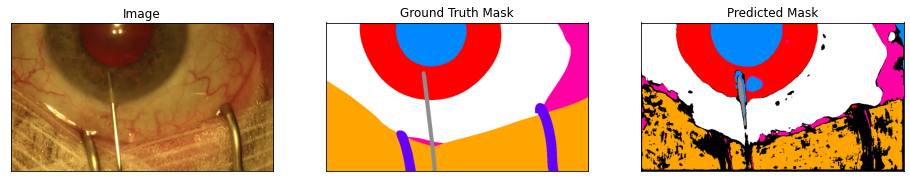

In [22]:

n = np.random.choice(len(test_dataset))
image_vis = test_dataset_vis[250][0].astype('uint8')
image, gt_mask = test_dataset[250]

gt_mask = one_mask(gt_mask.squeeze())

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0).float()
pr_mask = best_model.predict(x_tensor)
pr_mask = one_mask(pr_mask.squeeze().cpu().numpy().round())
gt_mask = mask_to_colormap(gt_mask, colormap)
pr_mask = mask_to_colormap(pr_mask, colormap)

visualize(
image=image_vis, 
ground_truth_mask=gt_mask, 
predicted_mask=pr_mask
)